# Imports

In [1]:
import sys
import warnings

# since mp3 formats are not "fully" supported by librosa
# this filters those out warning stating librosa is falling back on another package
warnings.filterwarnings('ignore') 

# installing all essential packages to run this file
!{sys.executable} -m pip install -r requirements.txt | grep -v 'already satisfied'

# for files, audio manipulation, and plotting
import csv
import random
import librosa
# import matplotlib
import numpy as np
import pandas as pd 
import seaborn as sns
import librosa.display
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from itertools import combinations 
from mpl_toolkits.mplot3d import Axes3D


# specific to training the model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, model_from_json 
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold, train_test_split
from keras.layers import LSTM, Dense, TimeDistributed, Activation, Dropout

print("Importing Complete")

Importing Complete


Using TensorFlow backend.


# Data Processing

## Transform Data

<pr> This subsection does NOT need to be run when using the program. It was used to initially load in all the audio files, take 100 mfccs, transform the data, and save the data as numpy arrays for future use. <pr>

In [ ]:
def process_data(num_coefficients):
    '''
    Loads in all the audio files from (https://toneperfect.lib.msu.edu/). 
    For each audio file, takes the preferred number of top Mel-frequency cepstrum coefficients (mfccs) and 
    saves the mcffs in an numpy array and its one hot encoded labels in another numpy array. 
    Order is maintained between both the data and label arrays. Pads all the audio files so they 
    are the same duration. Saves all data in a 3D binary numpy array with dimensions being file, 
    time, coefficients, in that order.
    
    @param num_coefficients --> the number of top mfccs to take from the tone perfect data 
    '''
    X = list()
    y = list()
    max_padding = 0

    data = Path('.gitignore/tone_perfect_mp3').iterdir()

    for item in data:
        if item.is_file():
            filename = item.name.split("_") #"{}{}_{}V{}_MP3.mp3".format(mword, tone, gender, personID)
            y.append(int(filename[0][-1]) - 1) #note: labeled 1 --> 4, and now 0 --> 3

            #transform all of the data to mfccs (Mel Frequency Cepstral Coefficients)
            #https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd
            audio, sampling_rate = librosa.load(item)
            mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=num_coefficients) 
            print(mfcc.shape)
            
            X.append(mfcc)
            total_audio_time = len(mfcc[0])
            if total_audio_time > max_padding: max_padding = total_audio_time
    
    #padding each audio file's mcffs with zero so all audio files are considered the same duration 
    for i in range(len(X)):
        X[i] = pad_sequences(X[i], padding='post', maxlen = max_padding)

    #transforming from (file, coefficients, time) to (file, time, coefficients)
    X = np.asarray(X, dtype=np.float32)
    X = np.transpose(X, (0, 2, 1))
    
    #save the numpy arrays to significatly cut down on run time 
    np.save('mcffs_{}.npy'.format(num_coefficients), X)
    np.save('labels_{}.npy'.format(num_coefficients), to_categorical(y, num_classes = 4)) 
    
    return None

process_data(100)

## Load and split data

In [ ]:
def load_data(num_coefficients):
    '''
    Loads in the data from the pre-processed saved data files that contain the top 100 mfccs for the tonal data
    and returns the data with the perferred number of mfccs
    
    @param num_coefficients --> the number of top mcffs to select for from the data
    @return (X, y) --> tuple containing all the data and labels, respectively
    '''
    X = np.load('mcffs_{}.npy'.format(100))
    y = np.load('labels_{}.npy'.format(100))

    X = X[:, :, 0:num_coefficients]
    
    return X, y


def split_data(X, y):
    '''
    Split data into 60% training, 20% testing, and 20% validation
    
    @param (X, y) --> tuple containing all the data and labels, respectively
    @return X_test, y_test, X_train, y_train, X_validation, y_validation --> labeled data split 60/20/20
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = .25)
    
    return X_test, y_test, X_train, y_train, X_validation, y_validation

# The Model

In [ ]:
# Websites I referenced:  
# https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
# https://adventuresinmachinelearning.com/keras-lstm-tutorial/

class BatchGenerator(object):
    '''
    Generator class used by model to return batches of the data for training and learning paramters
    '''

    def __init__(self, data, labels, timesteps, batch_size, num_tones):
        self.data = data
        self.labels = labels
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.num_tones = num_tones

    def generate_batch(self):
        # pre-shuffle all the indices so that every epoch's batch sampling is different
        randomized_indices = np.array([*range(0,len(self.data))])
        random.shuffle(randomized_indices)
        
        num_inter = 0
        while True:
            
            start_index = num_inter * self.batch_size
            batch_indices = randomized_indices[start_index: self.batch_size + start_index]
            data_batch = self.data[batch_indices]
            labels_batch = self.labels[batch_indices]
            
            yield data_batch, labels_batch
            
            #reshuffle batch indices after going through all the data
            num_inter += 1
            if len(self.data) <= (num_inter * self.batch_size):
                num_inter = 0
                random.shuffle(randomized_indices)

In [ ]:
def create_model(hidden_size, timesteps, num_mcffs, dropout_val):
    '''
    Constructs and returns an untrained Long Short-Term Memory (LSTM) model for the tonal data based on 
    the paramters provided. Assumes the number of tones is 4.
    
    @params hidden_size     --> size of the one hidden layer
            timesteps       --> number
            num_mcffs       --> number of coefficients
            dropout_val     --> dropout rate
            
    @return model --> untrained model
    '''
    num_tones = 4
    
    model = Sequential()
    model.add(LSTM(hidden_size, batch_input_shape=(None, timesteps, num_mcffs)))
    if dropout_val > 0.0:
        model.add(Dropout(dropout_val))
    model.add(Dense(num_tones))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    
    return model

In [ ]:
def tone_data_LSTM(train_data, train_labels, valid_data, valid_labels, num_epochs, dropout_val): 
    '''
    Constructs, trains and returns a Long short-term memory (LSTM) model for the tonal data based on 
    the paramters provided. Assumes the number of tones is 4, the batch size is 24, and the size of the hidden
    layer is 500.
    
    @params train_data      --> tonal data used for training
            train_labels    --> tonal labels that coincide with training data
            valid_data      --> tonal data used for validation
            valid_labels    --> tonal labels that coincide with validation data
            num_epochs      --> number of epochs to run the model on
            dropout_val     --> dropout rate
            
    @return model --> trained model
    '''
    num_tones = 4
    batch_size = 24
    hidden_size = 500

    timesteps = train_data.shape[1]
    num_mcffs = train_data.shape[2]
    
    X_train_generator = BatchGenerator(train_data, train_labels, timesteps, batch_size, num_tones)                                       
    X_validation_generator = BatchGenerator(valid_data, valid_labels, timesteps, batch_size, num_tones)
    
    model = create_model(hidden_size, timesteps, num_mcffs, dropout_val)
    
    checkpointer = ModelCheckpoint(filepath='model_checkpoints/model-{epoch:02d}.hdf5')
    model.fit_generator(X_train_generator.generate_batch(), 
                        len(train_data)//(batch_size*timesteps), 
                        num_epochs, 
                        validation_data = X_validation_generator.generate_batch(), 
                        validation_steps = len(valid_data)//(batch_size*timesteps), 
                        callbacks=[checkpointer])
    return model

## Testing Effect of Hyperparameters

In [ ]:
test_coefficients = np.arange(5,101,5)
hyperparameter_info = dict()

for num_coefficients in test_coefficients:
    X, y = load_data(num_coefficients)
    X_test, y_test, X_train, y_train, X_validation, y_validation = split_data(X, y)
    
    hyperparameter_info[num_coefficients] = list()
    
    testing_num_epochs = list(range(50, 301, 50))
    testing_dropout_vals = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

    for num_epochs in testing_num_epochs:
        for dropout_val in testing_dropout_vals:
            model = tone_data_LSTM(X_train, y_train, X_validation, y_validation, num_epochs, dropout_val)
            prediction = model.predict(X_validation)
            accuracy = np.sum(np.argmax(prediction, axis = 1) == y_validation)/len(y_validation)
            info = (num_epochs, dropout_val, accuracy)
            hyperparameter_info[num_coefficients].append(info)

In [ ]:
w = csv.writer(open("hyperparameter_testing.csv", "w"))
for coefficient, val in hyperparameter_info.items():
    for (num_epochs, dropout_val, accuracy) in val:
        w.writerow([coefficient, num_epochs, dropout_val, accuracy])

## Data Visualization

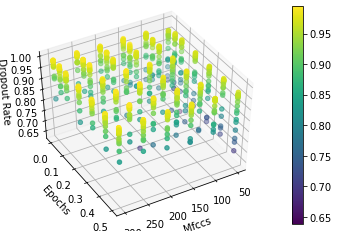

In [2]:
# 3D plot with accuracy color data point, as a "4th" dimension
testing_results = np.loadtxt('hyperparameter_testing.csv', delimiter = ',', skiprows= 1)

X = testing_results[:, 1] #num_coefficients
Y = testing_results[:, 2] #num_epochs
Z = testing_results[:, 3] #dropout_prob
accuracy = testing_results[:, -1] #acts as the fourth dimension by color mapping

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(45,60)
ax.set_xlabel("Mfccs")
ax.set_ylabel("Epochs")
ax.set_zlabel("Dropout Rate")
img = ax.scatter(X,Y,Z, c = accuracy, cmap = plt.viridis())
fig.colorbar(img)
plt.show()
fig.savefig('3D.png', dpi=fig.dpi)

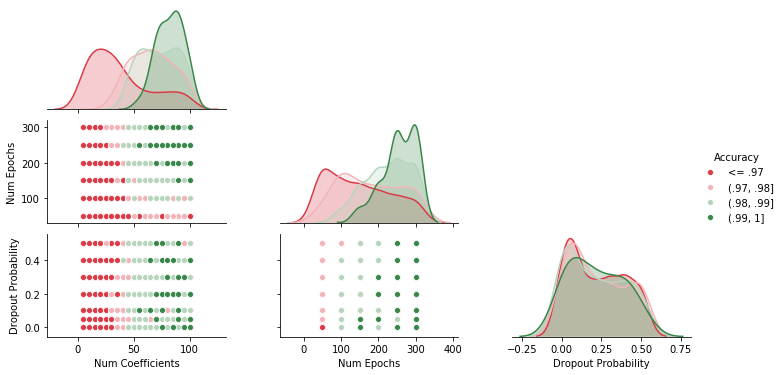

In [3]:
# pair plots
testing_results = pd.read_csv("hyperparameter_testing.csv")

accuracy = np.asarray(testing_results["Accuracy"])
colors = np.empty(accuracy.shape, dtype = 'U25')
colors[accuracy <= .97] = '<= .97'
colors[(accuracy > .97) & (accuracy <= .98)] = '(.97, .98]'
colors[(accuracy > .98) & (accuracy <= .99)] = '(.98, .99]'
colors[(accuracy > .99) & (accuracy <= 1)] = '(.99, 1]'

testing_results['Accuracy'] = colors
colors = sns.diverging_palette(10, 133, n = 4)
pair_plot = sns.pairplot(data=testing_results,
                  hue="Accuracy", palette=colors,
                  size=1.8, aspect=1.8, corner=True)

fig = pair_plot.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.savefig('pair_plots.png', dpi=fig.dpi)

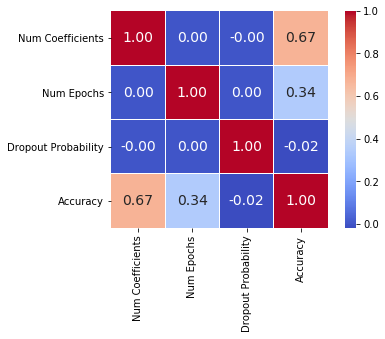

In [4]:
# heat maps showing the correlation between all variables
testing_results = pd.read_csv("hyperparameter_testing.csv")

corr = testing_results.corr()
heat_map = sns.heatmap(corr, 
                 cmap="coolwarm", 
                 square=True, 
                 annot=True, 
                 fmt='.2f', 
                 annot_kws={"size": 14},
                 linewidths=.05)

fig = heat_map.get_figure()    
fig.savefig("heat_map.png", dpi=fig.dpi)

## 10-Fold Cross Validation 

In [ ]:
#pre-selecting all accuracies from the hyperparameter testing that are above .9935 (5 total)
testing_results = pd.read_csv("hyperparameter_testing.csv")
top_performers = np.asarray(testing_results.loc[testing_results['Accuracy'] > 0.9935])[:, :-1]

#perform 10 fold cross validation an the sets of parameters pre-selected above
performances = []

for num_coefficients, num_epochs, dropout_rate in top_performers:
    X, y = load_data(int(num_coefficients))
    
    accuracies = []
    
    for train_index, test_index in KFold(10, shuffle=True).split(X):
  
        X_train, y_train = X[train_index], y[train_index]
        X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = .5)
        
        model = tone_data_LSTM(X_train, y_train, X_validation, y_validation, num_epochs, dropout_rate)
        ___, test_accuracy = model.evaluate(X[test_index], y[test_index], verbose=1)
        accuracies.append(test_accuracy)
        
    performances.append(np.mean(accuracies))

cross_validation_data = pd.DataFrame(np.hstack((top_performers,np.asarray(performances).reshape(5,1))),
                                    columns = ["Num Coefficients","Num Epochs", "Dropout Probability", "Accuracy"])
cross_validation_data.to_csv('cross_validation_results.csv') 

# Training and Saving The Optimal Model

In [ ]:
# selecting the model that had the highest accuracy during 10-fold cross validation
validation_results = pd.read_csv("cross_validation_results.csv")
top_accuracy = validation_results['Accuracy'].max()
top_performer = validation_results[validation_results['Accuracy'] == top_accuracy]

# getting the optimal hyperparameters
num_coefficients, num_epochs, dropout_rate = np.asarray(top_performer)[:, 1:-1][0]

# data
X, y = load_data(int(num_coefficients))
X_test, y_test, X_train, y_train, X_validation, y_validation = split_data(X,y)

# training
model = tone_data_LSTM(X_train, y_train, X_validation, y_validation, num_epochs, dropout_rate)

# saving model
# Found from: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model.h5")

In [ ]:
file = open('model_spec.txt', 'w')
file.write("No. of coefficients: {}".format(num_coefficients)) 
file.write("\nNo. of epochs: {}".format(num_epochs)) 
file.write("\nNo. of dropout_rate: {}".format(dropout_rate)) 
file.write("\nModel Accuracy from 10-Fold cross validation: {}".format(top_accuracy)) 
file.close() 

# User Interface

<pr> User's should interact with the notebook through this section. All imports that are needed are included under the import section right below. Once that is run, the use can load in the model that was previously found to have the highest accuracy. From there, the user can create a folder to hold all their recordings in case they want to go back to them later and listen to themselves learn over time. The user is then able to record their voice, play it back, and and get real time auditory feedback from the model predicting their tone. They may do this as many times as they wish! At the end, they can delete all their recordings. In order to run a cell, a user should click on the cell, then press the run button up above. Have fun and good luck in learning Mandarin tones! <pr>

## Imports

In [ ]:
# since mp3 formats are not "fully" supported by librosa
# this filters those out warning stating librosa is falling back on another package
import sys
import warnings
warnings.filterwarnings('ignore') 

# installing all essential packages to run this file
!{sys.executable} -m pip install -r requirements.txt | grep -v 'already satisfied'

import os
import time
import shutil
import librosa
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from keras.models import model_from_json
from keras.preprocessing.sequence import pad_sequences

print("Importing Complete")

## Load in the model 

In [ ]:
# Found from: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
json_file = open('model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

# load weights into new model
model.load_weights("model.h5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print("Model Loaded")

file = open('model_spec.txt', 'r') 
print(file.read())
file.close()

## Create folder to hold user audio
<p> Run the following cell to remove previous user audio and make the folder to hold all user input audio. <p>

In [ ]:
#initializing folder to hold user audio
user_audio_directory = ("user_audio")
try:
    shutil.rmtree(user_audio_directory)
    os.makedirs(user_audio_directory)
    print("Removed data and recreated folder", user_audio_directory)
except(FileNotFoundError):
    os.makedirs(user_audio_directory)
    print("Created folder {}".format(user_audio_directory)) 

## Record user's voice

<pr> Users are encouraged to only record clear monosyllabic words in order to practice tonalities.<pr>

In [ ]:
frame_rate = 44100
duration = 1.4 #aligns with the max time for the data recordings [sec]

print("Recording in...")
pause = 3

while pause > 0:
    print("{}".format(pause))
    pause -= 1
    time.sleep(1)
print("RECORDING")

recording = sd.rec(int(duration * frame_rate), samplerate = frame_rate, channels = 1)
recording_num = len(os.listdir('user_audio/')) + 1
recording_name = 'user_audio/sample_audio_{}.mp3'.format(recording_num)
sd.wait()
write(recording_name, frame_rate, recording)

print("\nFinished")

## Plot, playback, and prediction of user recording 
<pr> User can play back and see a visualization of their latest recording as many times as they like. <pr>

In [ ]:
try: 
    audio, sampling_rate = librosa.load(recording_name, duration=1.5)
    
    ###plot##
    timeline = np.arange(0, len(audio))/sampling_rate
    fig = plt.figure()
    plt.plot(timeline, audio)
    plt.xlabel("Time (s)", fontsize=18)
    plt.ylabel("Amplitude", fontsize=16)
               
    ###playback##
    sd.play(audio, sampling_rate)
    sd.wait()
    sd.stop()
    
    ##predict##
    #transform data
    user_mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=80) 
    padded_user_mfcc = np.asarray([pad_sequences(user_mfcc, padding='post', maxlen = 60)])
    user_audio_test_data = np.transpose(padded_user_mfcc, (0, 2, 1))
    
    #predict tone using model
    prediction_accuracies = model.predict(user_audio_test_data) 
    predicted_tone = np.where((prediction_accuracies > 0.5).astype("int32")[0] == 1)[0][0]
    
    #report prediction
    tone = predicted_tone+ 1 #accounting for data labels being indexed at zero
    closeness = "{:.2%}".format(prediction_accuracies[0][predicted_tone])

    print("The model predicts you are speaking in tone {} with an accuracy of {}.".format(tone, closeness))
    
except(FileNotFoundError):
    print("Please go back and run the previous two cells")

# Delete all user recordings

In [ ]:
user_audio_directory = ("user_audio")
try:
    shutil.rmtree(user_audio_directory)
    print("Successfully removed user data")
except(FileNotFoundError):
    print("User data already deleted".format(user_audio_directory)) 